<a href="https://colab.research.google.com/github/1kaiser/test2022/blob/main/TESTING_positional_encoding_taylor_series_Matrix_multiply_einsum_Runge_kutta_physics_informed_neural_network_(PINN)_in_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Position encoder

In [20]:
def sin5q(x):
        A = 6.28230858
        B = -41.1693687
        C = 74.4388885
        x2 = x * x
        return x * (A + x2 * (B + x2 * C))
    
def sin(x):
        pi2 = 1 / (2 * 3.1415926535)
        x_2 = 0.25 - x * pi2;
        z = 0.25 - abs(x_2 - round(x_2))
        #print(sin5q(z))
        return sin5q(z)
    
def cos(x):
        pi2 = 1 / (2 * 3.1415926535)
        x_2 = x * pi2
        z = 0.25 - abs(x_2 - round(x_2))
        #print(sin5q(z))
        return sin5q(z)

c_near_bound = 2.                                                          # Near Bound of sample space for 3d points
c_far_bound = 6.                                                           # Far Bound of sample space for 3d points
c_batch_size = int(1e4)                                                    # Batch Size
c_num_sample_points = 256                                                  # Number of points to be sampled across the volume
c_epsilon = 1e10                                                           # Hyperparameter for volume rendering
c_apply_positional_encoding = True                                         # Apply posittional encoding to the input or not
c_positional_encoding_dims = 6                                             # Number of positional encodings applied
c_num_dense_layers = 8                                                     # Number of dense layers in MLP
c_dense_layer_width = 256                                                  # Dimentionality of dense layers' output space 
c_learning_rate = 5e-4                                                     # Learning Rate
c_train_epochs = 1000                                                      # Number of training epochs
c_plot_interval = 100                                                      # Epoch interval for plotting results during training

file_name = "tiny_nerf_data.npz"                                                # Download the data if it does not already exist.
url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"
import os 
import tensorflow as tf
from tensorflow import keras
if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=url)

import numpy as np
data = np.load(data)
images = data["images"]
_, image_height, image_width, _ = images.shape
################################################################################
def positional_encoding(inputs):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(                                                     # Applying vmap transform to vectorize the multiplication operation
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(c_positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    #periodic_fns = jnp.stack([sin(inputs_freq), cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns
################################################################################
################################################################################
!pip3 install -q -U flax
import flax
import flax.linen as nn
from typing import Any
import jax
from jax import lax
import jax.numpy as jnp
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32                                                    # dtype of the computation
    precision: Any = lax.Precision.DEFAULT                                      # numerical precision of the computation (set to bfloat16 by default)
    apply_positional_encoding: bool = c_apply_positional_encoding          # Apply positional ecoding or not

    @nn.compact
    def __call__(self, input_points):
      x = positional_encoding(input_points) if self.apply_positional_encoding else input_points 	# Apply positional encoding to the input points
      for i in range(c_num_dense_layers):                                #c_num_dense_layers = 8 # Number of dense layers in MLP
          x = nn.Dense(                                                       # Fully-connected layer
              c_dense_layer_width,                                       #c_dense_layer_width = 256 # Dimentionality of dense layers' output space 
              dtype=self.dtype,                                               #dtype: Any = jnp.float32
              precision=self.precision                                        # numerical precision of the computation (set to bfloat16 by default) precision: Any = lax.Precision.DEFAULT
          )(x)            
          x = nn.relu(x)                                                      # ReLU activation function
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x    # Skip connection
      x = nn.Dense(4, dtype=self.dtype, precision=self.precision)(x)                # Output consists of 4 values: (r, g, b, sigma)
      return x
################################################################################
################################################################################
def initialize_model(key, input_pts_shape):
    model = NeRFModel()                                                         # Create an instance of the model
    initial_params = jax.jit(model.init)({"params": key},jnp.ones(input_pts_shape),)# Initialize the model parameters
    return model, initial_params["params"]
################################################################################
import jax
key, rng = jax.random.split(jax.random.PRNGKey(0))                              # Random Number Generator
model, params = initialize_model(key, (image_height * image_width, 3))          # Initialize the Model
n_devices = jax.local_device_count()                                            # Number of accelerators
import optax
optimizer = optax.adam(learning_rate=c_learning_rate)                           # Define the Optimizer
import flax
from flax.training import train_state, common_utils
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)# Create the Training State
state = jax.device_put_replicated(state, jax.local_devices())                   # Transfer arrays in the state to the specified devices and form ShardedDeviceArrays











In [21]:
state

TrainState(step=ShardedDeviceArray([0], dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of NeRFModel(
    # attributes
    dtype = float32
    precision = <Precision.DEFAULT: 0>
    apply_positional_encoding = True
)>, params=FrozenDict({
    Dense_0: {
        bias: ShardedDeviceArray([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [15]:
model, params = initialize_model(key, (image_height * image_width, 3))   
print(model.summary())

AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3611: UserWarning: Explicitly requested dtype double requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


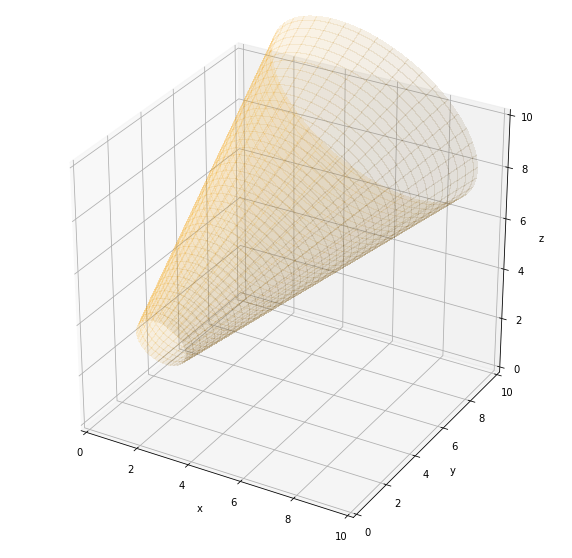

value t :: [1.8804659 3.6542268 2.5871384 3.2432384 2.4349902 3.9772713 3.8801363
 3.264447  3.9337132 3.289604  2.3287292 3.1466024 3.7500925 3.0505004
 3.3556426 3.0944202 2.9937    3.800906  3.5145442 3.157154  3.4823198
 3.5029259 2.3202915 3.6344094 3.4301574 3.2360082 3.52725   2.206632
 3.9873958 3.4468675 2.144674  2.9103484 3.4278913 1.7484049 3.688784
 3.1187375 2.007457  2.2608793 2.0740986 2.950224  3.376957  3.55306
 3.5306926 2.5876794 2.0352013 3.5241754 2.7363715 2.7070513 2.033432
 3.519129  3.099997  3.837235  3.9518352 2.431132  3.9260397 3.0717547
 3.3978753 3.7259343 3.3610976 3.4727607 3.5979908 2.3505158 3.695806
 3.906493  3.1784465 3.467738  1.9514574 2.6306827 2.6281493 3.5342054
 2.8178656 1.6783906 3.6811764 1.9499865 2.4537184 3.122555  3.5872097
 3.413894  3.0883381 3.776516  2.5354593 2.2810647 3.1526246 2.119592
 3.8615386 3.859492  2.958629  3.791692  1.1679844 1.9459628 2.1173406
 2.8350015 3.5159898 2.591852  3.8854225 1.9513798 3.865398  2.3465402
 2

<Figure size 1080x1080 with 0 Axes>

In [ ]:
import jax.numpy as jnp

def sin5q(x):
        A = 6.28230858
        B = -41.1693687
        C = 74.4388885
        x2 = x * x
        return x * (A + x2 * (B + x2 * C))
    
def sin(x):
        pi2 = 1 / (2 * 3.1415926535)
        x_2 = 0.25 - x * pi2;
        z = 0.25 - abs(x_2 - round(x_2))
        #print(sin5q(z))
        return sin5q(z)
    
def cos(x):
        pi2 = 1 / (2 * 3.1415926535)
        x_2 = x * pi2
        z = 0.25 - abs(x_2 - round(x_2))
        #print(sin5q(z))
        return sin5q(z)


def pos_enc(x, min_deg, max_deg, append_identity=True):
  """The positional encoding used by the original NeRF paper."""
  scales = jnp.array([2**i for i in range(min_deg, max_deg)])
  xb = jnp.reshape((x[..., None, :] * scales[:, None]),
                   list(x.shape[:-1]) + [-1])
  four_feat = jnp.sin(jnp.concatenate([xb, xb + 0.5 * jnp.pi], axis=-1))
  if append_identity:
    return jnp.concatenate([x] + [four_feat], axis=-1)
  else:
    return four_feat

def stable_pos_enc(x, n):
  """A stable posenc for very high degrees, courtesy of Sameer Agrawal."""
  sin_x = sin(x)
  cos_x = cos(x)
  output = []
  rotmat = jnp.array([[cos_x, -sin_x], [sin_x, cos_x]], dtype='double'); #print("rotmat :\n\n",rotmat,"\n\n :: end rotmat")
  for _ in range(n):
    output.append(rotmat[::-1, 0, :])
    rotmat = jnp.einsum('ijn,jkn->ikn', rotmat, rotmat); #print("rotmat :\n\n",rotmat,"\n\n :: end rotmat")
  return jnp.reshape(jnp.transpose(jnp.stack(output, 0), [2, 1, 0]), [-1, 2 * n])


n = 10
x = jnp.linspace(-1, 1, 100)
z = pos_enc(x[:, None], 0, n, append_identity=False)
z_stable = stable_pos_enc(x, n); #print("rotmat :\n\n",z_stable,"\n\n :: end rotmat")
#jnp.max(jnp.abs(z - z_stable))
#x[:, None]


from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10  , 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')


def truncated_cone(p0, p1, R0, R1, color):
    """
    Based on https://stackoverflow.com/a/39823124/190597 (astrokeat)
    """
    # vector in direction of axis
    v = p1 - p0
    # find magnitude of vector
    mag = norm(v)
    # unit vector in direction of axis
    v = v / mag
    # make some vector not in the same direction as v
    not_v = jnp.array([1, 1, 0])
    if (v == not_v).all():
        not_v = jnp.array([0, 1, 0])
    # make vector perpendicular to v
    n1 = jnp.cross(v, not_v)
    # print n1,'\t',norm(n1)
    # normalize n1
    n1 /= norm(n1)
    # make unit vector perpendicular to v and n1
    n2 = jnp.cross(v, n1)
    # surface ranges over t from 0 to length of axis and 0 to 2*pi
    n = 80
    t = jnp.linspace(0, mag, n)
    theta = jnp.linspace(0, 2 * jnp.pi, n)
    # use meshgrid to make 2d arrays
    t, theta = jnp.meshgrid(t, theta)
    R = jnp.linspace(R0, R1, n)
    # generate coordinates for surface
    X, Y, Z = [p0[i] + v[i] * t + R *
               sin(theta) * n1[i] + R * cos(theta) * n2[i] for i in [0, 1, 2]]
    ax.plot_surface(X, Y, Z, color=color, linewidth=0, antialiased=False, alpha = .1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 10)



import jax.random as random
rng = random.PRNGKey(0)
def sample_conical_frustum(rng, num_samples, d, t0, t1, base_radius):
  """Draw random samples from a conical frustum.
  Args:
    rng: The RNG seed.
    num_samples: int, the number of samples to draw.
    d: jnp.float32 3-vector, the axis of the cone.
    t0: float, the starting distance of the frustum.
    t1: float, the ending distance of the frustum.
    base_radius: float, the scale of the radius as a function of distance.
  Returns:
    A matrix of samples.
  """
  key, rng = random.split(rng)
  u = random.uniform(key, shape=[num_samples])
  t = (t0**3 * (1 - u) + t1**3 * u)**(1 / 3)
  key, rng = random.split(rng)
  theta = random.uniform(key, shape=[num_samples], minval=0, maxval=jnp.pi * 2)
  key, rng = random.split(rng)
  r = base_radius * t * jnp.sqrt(random.uniform(key, shape=[num_samples]))

  d_norm = d / jnp.linalg.norm(d)
  null = jnp.eye(3) - d_norm[:, None] * d_norm[None, :]
  basis = jnp.linalg.svd(null)[0][:, :2]
  rot_samples = ((basis[:, 0:1] * r * cos(theta)) +
                 (basis[:, 1:2] * r * sin(theta)) + d[:, None] * t).T
  return rot_samples

def surface_stats(points):
  """Get the sample mean and covariance matrix of a set of matrices [..., d]."""
  means = jnp.mean(points, -1)
  centered = points - means[..., None]
  covs = jnp.mean(centered[..., None, :, :] * centered[..., :, None, :], -1)
  return means, covs

def conical_frustum_to_gaussian_sample(key, raydir, t0, t1, r):
  """A brute-force numerical approximation to conical_frustum_to_gaussian()."""
  # Sample uniformly from a cube that surrounds the entire conical frustum.
  samples = sample_conical_frustum(key, 100000, raydir, t0, t1, r)
  # Compute their mean and covariance.
  return surface_stats(samples.T)

A0 = jnp.array([1, 3, 2])
A1 = jnp.array([8, 5, 12])
truncated_cone(A0, A1, 1, 4, 'orange')
plt.show()
#############################################################
key, rng = random.split(rng)
sha = 1000
u = random.uniform(key, shape=[sha]);t0=1;t1=4;
t = (t0**3 * (1 - u) + t1**3 * u)**(1 / 3); print("value t ::",t,t.shape, u.shape,"\n")
theta = random.uniform(key, shape=[sha], minval=0, maxval=jnp.pi * 2)
r = 2 * t * jnp.sqrt(random.uniform(key, shape=[sha]))
d= A0
d_norm = d / jnp.linalg.norm(d)
null = jnp.eye(3) - d_norm[:, None] * d_norm[None, :]
basis = jnp.linalg.svd(null)[0][:, :2]
rot_samples = ((basis[:, 0:1] * r * cos(theta)) +
               (basis[:, 1:2] * r * sin(theta)) + d[:, None] * t).T
print("rot samples",rot_samples.T, rot_samples.T.shape)         
means = jnp.mean(rot_samples.T, -1)
print(means.shape,means)
centered = rot_samples.T - means[..., None]
covs = jnp.mean(centered[..., None, :, :] * centered[..., :, None, :], -1)
print("\ncovs::\n",covs.T.shape,covs.T)
#############################################################
plot2 = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 10)
ax.scatter3D((rot_samples.T)[0,:], (rot_samples.T)[1,:], (rot_samples.T)[2,:], c=(rot_samples.T)[2,:], cmap='Greens')
#ax.plot_surface((rot_samples.T)[0,:], (rot_samples.T)[1,:],(rot_samples.T)[2,:], linewidth=0, antialiased=False, alpha = .1)

(3,) [3.121038 9.764847 5.05355 ]


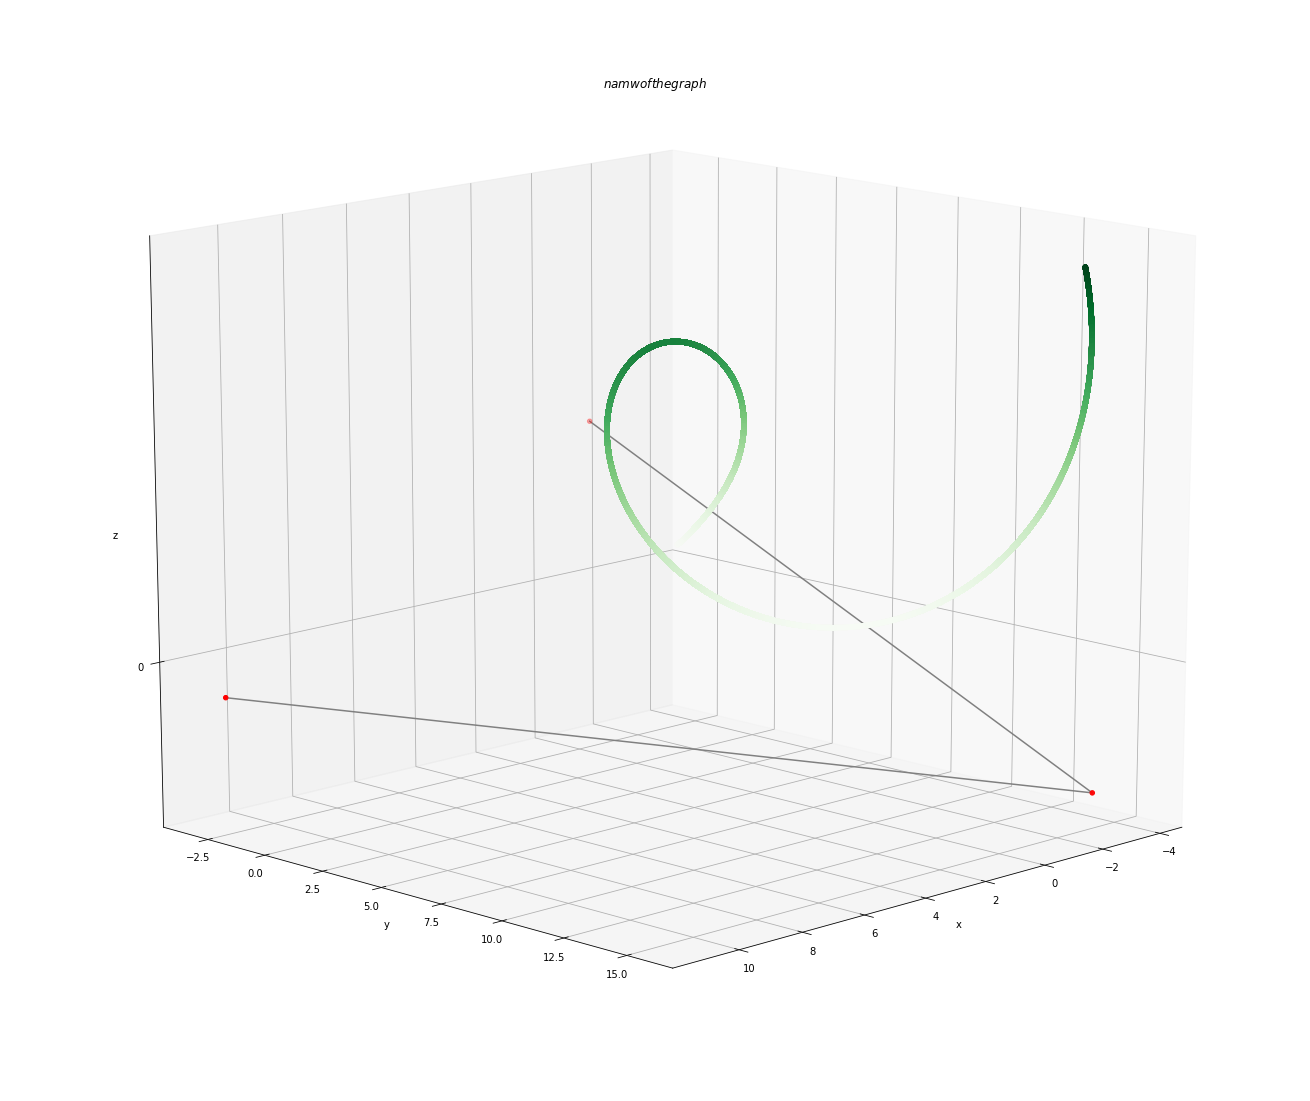

In [ ]:
#############################################################
key, rng = random.split(rng)
sha = 100000
u = random.uniform(key, shape=[sha]);t0=1;t1=4;
t = (t0**3 * (1 - u) + t1**3 * u)**(1 / 3); #print("value t ::",t,t.shape, u.shape,"\n")
theta = random.uniform(key, shape=[sha], minval=0, maxval=jnp.pi * 2)
r = 2 * t * jnp.sqrt(random.uniform(key, shape=[sha]))
d= A0
d_norm = d / jnp.linalg.norm(d)
null = jnp.eye(3) - d_norm[:, None] * d_norm[None, :]
basis = jnp.linalg.svd(null)[0][:, :2]
rot_samples = ((basis[:, 0:1] * r * cos(theta)) +
               (basis[:, 1:2] * r * sin(theta)) + d[:, None] * t).T
#print("rot samples",rot_samples.T, rot_samples.T.shape)         
means = jnp.mean(rot_samples.T, -1)
print(means.shape,means)
centered = rot_samples.T - means[..., None]
covs = jnp.mean(centered[..., None, :, :] * centered[..., :, None, :], -1)
#print("\ncovs::\n",covs.T.shape,covs.T)
#############################################################
basis = jnp.linalg.svd(jnp.eye(3)-d_norm[:, None] * d_norm[None, :])[0][:, :2]
rot_samples = ((basis[:, 0:1] * r * cos(theta)) +
               (basis[:, 1:2] * r * sin(theta)) + d[:, None] * t).T
(rot_samples.T)[0,:].shape
#print((rot_samples.T)[1,:],"\n\n\n",(rot_samples.T)[0,:],"\n\n\n",(rot_samples.T)[2,:])

#ax.plot((rot_samples.T)[0,:], (rot_samples.T)[1,:], (rot_samples.T)[2,:], linewidth=0, antialiased=False, alpha = .1)
fig1 = plt.figure(figsize = (20,20))
ax = fig1.add_subplot(1, 1, 1, projection='3d')
ax.set_title("$namw ofthe graph$")
#ax.plot_surface((rot_samples.T)[0,:], (rot_samples.T)[1,:], (rot_samples.T)[0:1,:], rstride = 3, cstride = 3, cmap = 'cividis',antialiased=False, alpha=.6)
#ax.plot3D((rot_samples.T)[0,:], (rot_samples.T)[1,:], (rot_samples.T)[2,:],'gray')
from mpl_toolkits.mplot3d import axes3d  
X, Y, Z = axes3d.get_test_data(0.1)
ax.scatter3D((rot_samples.T)[0,:], (rot_samples.T)[1,:], (rot_samples.T)[2,:], c=(rot_samples.T)[2,:], cmap='Greens')
ax.plot3D((covs.T)[0,:], (covs.T)[1,:], (covs.T)[2,:],'gray')
ax.scatter3D((covs.T)[0,:], (covs.T)[1,:], (covs.T)[2,:], c='r', cmap='Purples')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.zaxis.set_major_locator(plt.MultipleLocator(60))
plt.subplots_adjust(left=0.0)
ax.view_init(15, 45)
ax.axis('on')
plt.savefig('example.png', dpi=320)


#Taylor expansion

In [ ]:
%config InlineBackend.figure_format = 'retina'
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [ ]:
def g(x, y):
  """Function """  
  return x ** 2 + 2 * x * y + y ** 3

In [ ]:
x = jnp.linspace(-5, 5, 5)
y = jnp.linspace(-5, 5, 5)
X, Y = jnp.meshgrid(x, y)
print("meshgrid X:: \n\n",X,"\nmeshgrid Y:: \n\n",Y)
Z = g(X, Y)
print("\nelevations :::\n\n\n",Z)
import jax as jax
x.shape
Df = jax.jacfwd(g, argnums=(0,1))
D2f = jax.jacfwd(Df, argnums=(0,1))(X,Y)
print("\nsmmall elevations :::\n\n\n",D2f)

In [ ]:
#%%timeit
H = jnp.asarray(jax.jacfwd(jax.jacfwd(g, argnums=(0,1)), argnums=(0,1))(1., 2.))
H

DeviceArray([[ 2.,  2.],
             [ 2., 12.]], dtype=float32)

In [ ]:
def Hessian(g_function):
  Df = jax.jacfwd(g_function, argnums=(0,1))#first differential
  D2f = jax.jacfwd(Df, argnums=(0,1))#second differential
  return D2f
H = jnp.asarray(Hessian(g)(1.,2.))#Hessian(function)(xvalue,yvalue)
H

DeviceArray([[ 2.,  2.],
             [ 2., 12.]], dtype=float32)

In [ ]:
delta = jnp.array([1., 1.]) -  jnp.array([1.0, 2.0])
jnp.trace(.5 * H@jnp.einsum('i,j', delta, delta))

DeviceArray(6., dtype=float32)

AttributeError: ignored

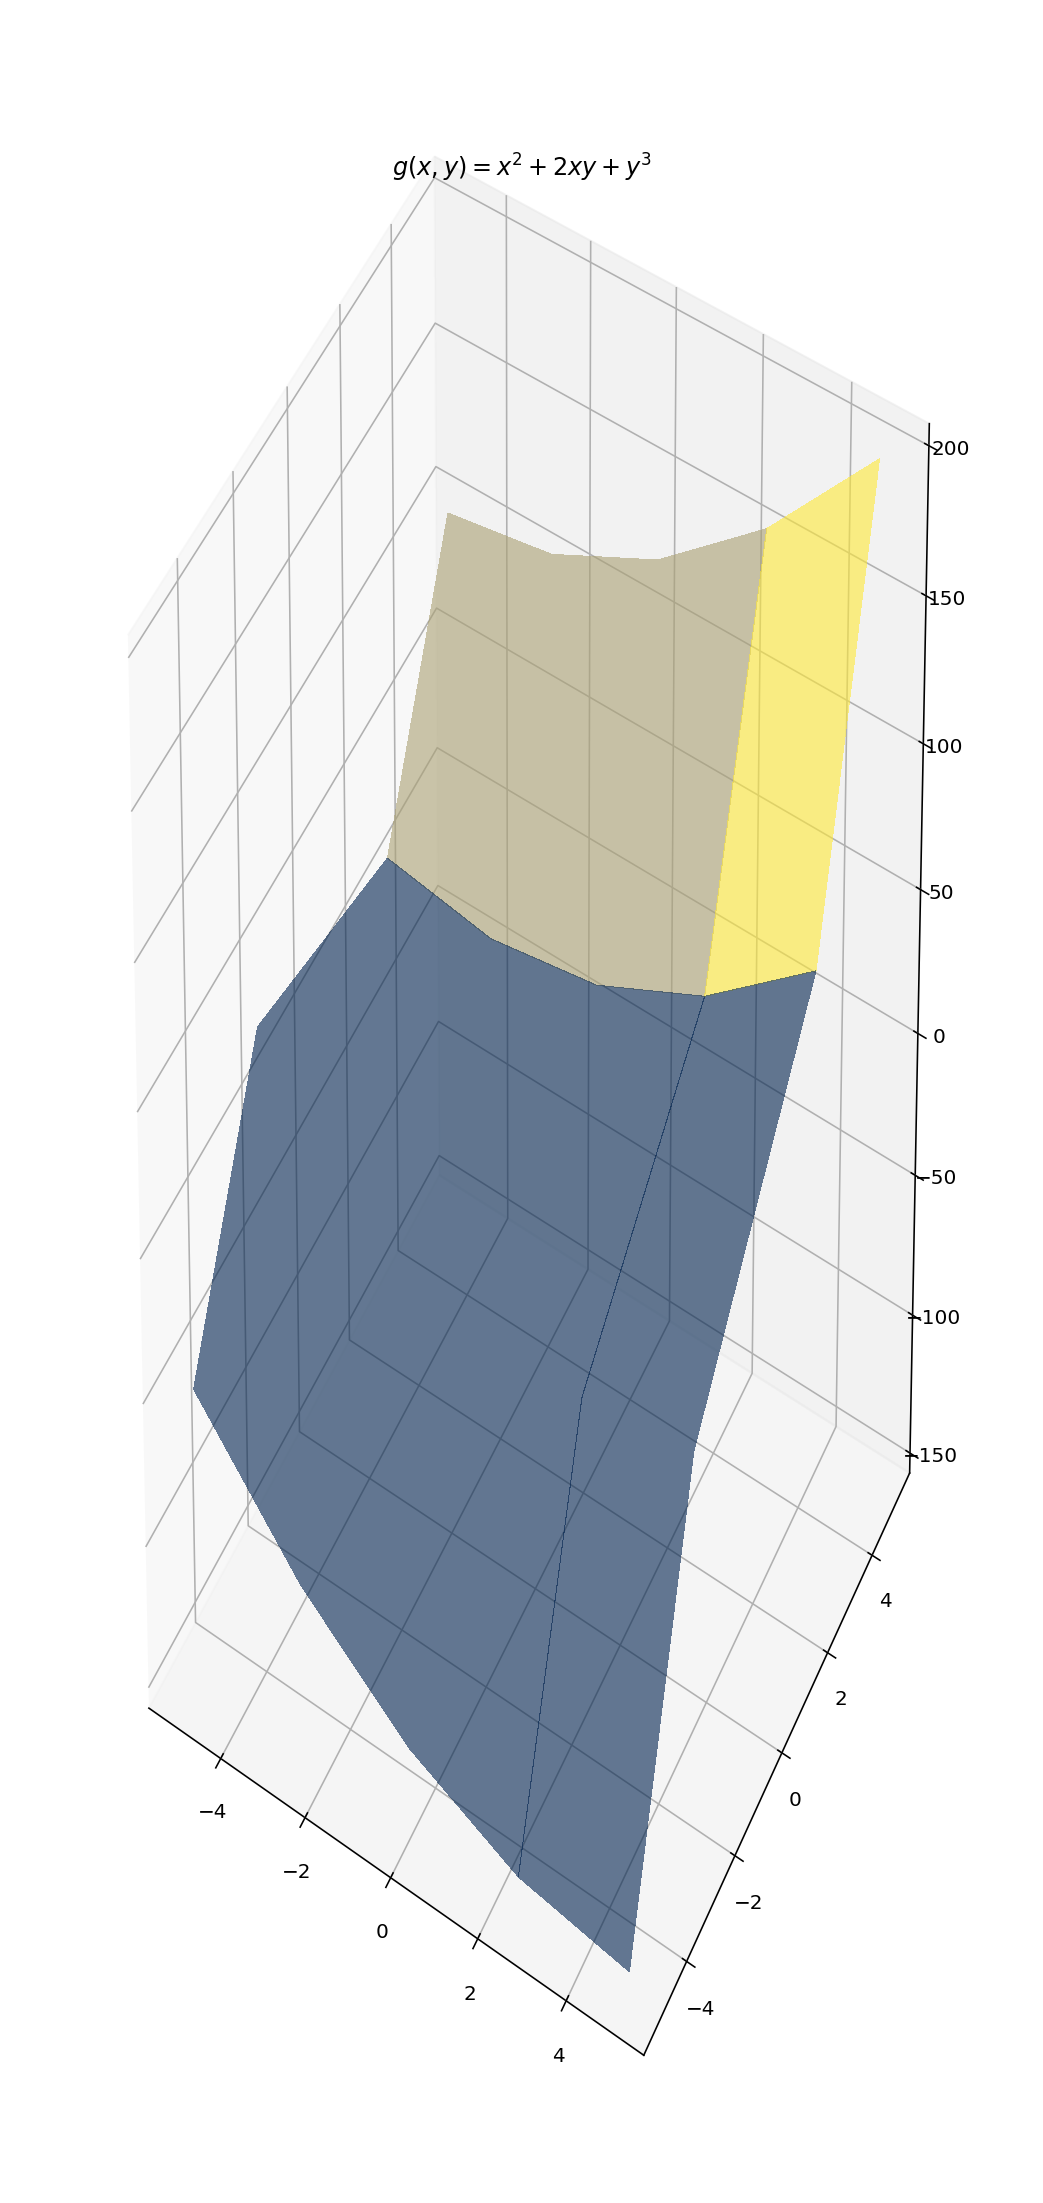

In [ ]:
#fig = plt.figure(figsize = (7.2, 4.3))
fig = plt.figure(figsize = (20  , 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title("$g(x,y)=x^2+2xy+y^3$")
ax.plot_surface(X, Y, Z, rstride = 3, cstride = 3, cmap = 'cividis',antialiased=False, alpha=.6, zorder=0.5)

ax.plot_surface(X, Y, z, rstride = 3, cstride = 3, cmap = 'PuBuGn',antialiased=False, alpha=.3,  zorder=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.zaxis.set_major_locator(
plt.MultipleLocator(60))
plt.subplots_adjust(left=0.0)
ax.view_init(15, 45)
ax.axis('off')
plt.savefig('taylor_2var_example.png', dpi=320)

# Testing & learning matrix multiplication ( **M @ X + C** )  and  **jax.numpy.einsum()**

In [ ]:
import jax.numpy as jnp
import jax.random as random

x = jnp.linspace(-10, 10, 5)
key=random.PRNGKey(0)
random.shuffle(key,x)
X,Y =jnp.meshgrid(x,random.permutation(key,x))

%timeit -n50 z=X@Y #50 loops, best of 5: 10.4 µs per loop
%timeit -n50 z=jnp.einsum('ik,kj->ij',X,Y) #50 loops, best of 5: 74.2 µs per loop

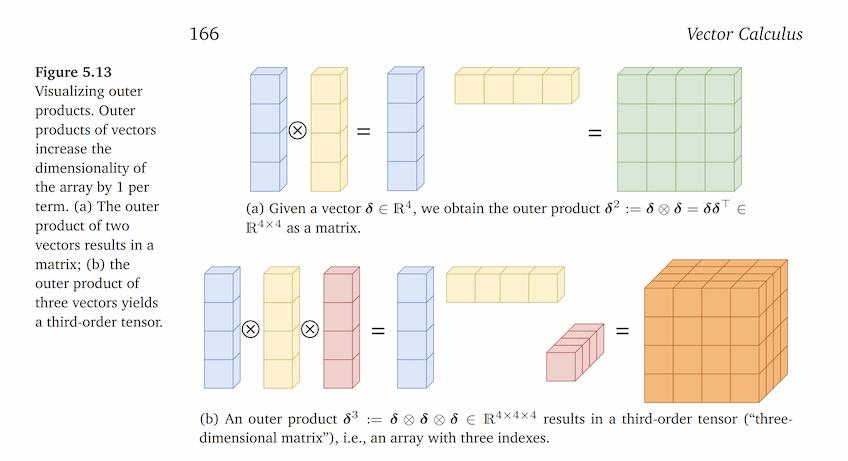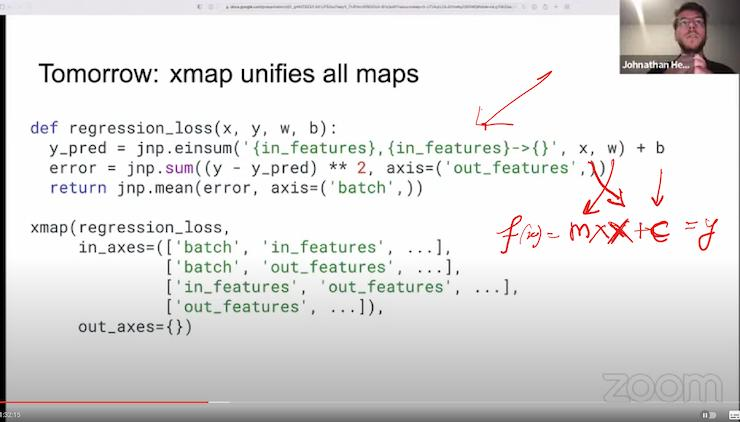

/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:366: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


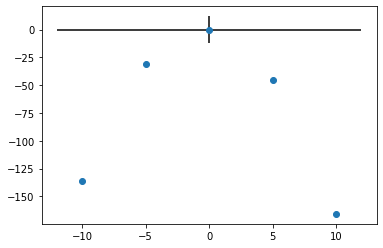

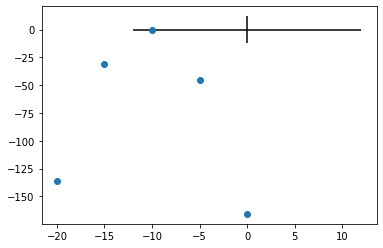

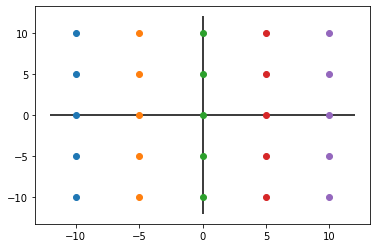

50 loops, best of 5: 10.4 µs per loop
(5, 5) 


 [[125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]]


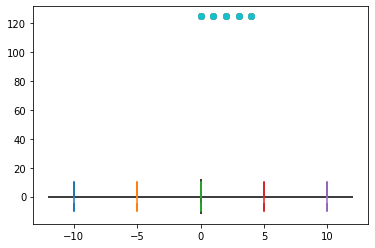

50 loops, best of 5: 74.2 µs per loop
(5, 5) 


 [[125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]
 [125. 125. 125. 125. 125.]]


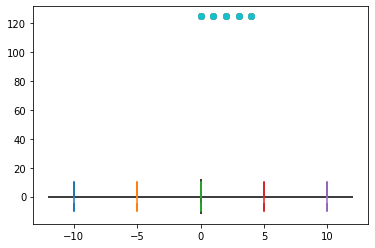

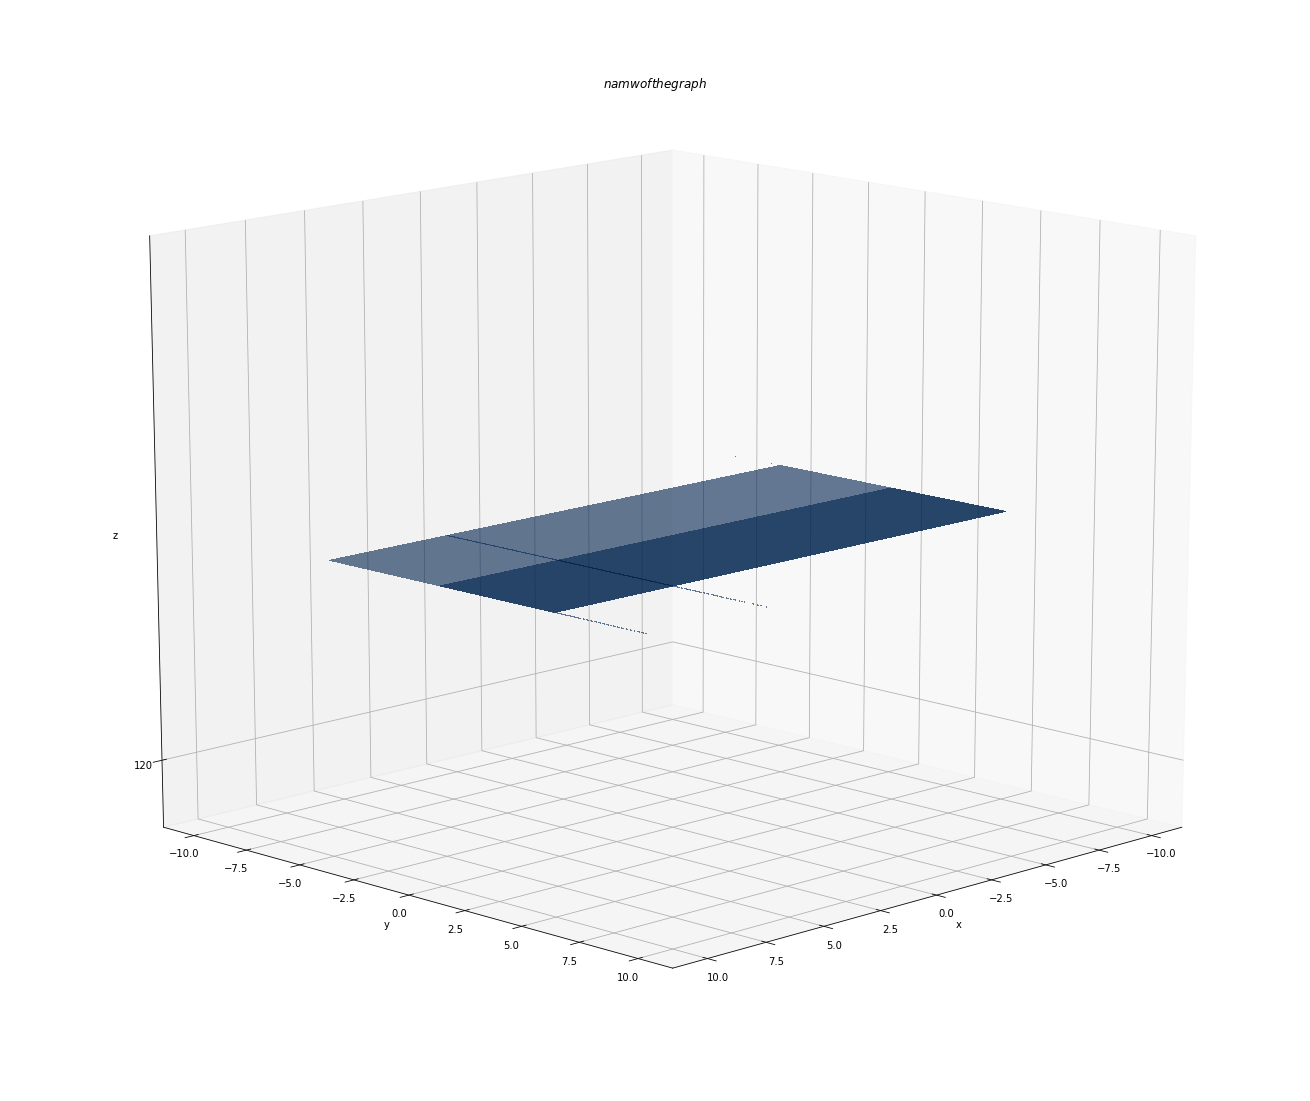

In [ ]:
from jax._src.numpy.lax_numpy import einsum
import numpy as np
import jax.numpy as jnp
import jax as jax
import jax.random as random
import matplotlib.pyplot as plt
from jax import make_jaxpr


def y(x, m, c):
  return m * x + c + m*x**2

x = jnp.linspace(-10, 10, 5)
key=random.PRNGKey(0)
random.shuffle(key,x)

m_true = -1.5
b_true = 2.0

y_true = y(x, m_true, b_true)

noise = ((random.permutation(key,*y_true.shape) *.05) - 1) * 3
y_true += noise

plot1 = plt.plot(x, y_true, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

plot2 = plt.plot(x-10, y_true, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

X,Y =jnp.meshgrid(x,random.permutation(key,x))
plot3 = plt.plot(X, Y, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

%timeit -n50 z=X@Y
z=X@Y
plot4 = plt.plot(X, Y,z, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
print(z.shape,"\n\n\n",z)
plt.show()

%timeit -n50  z=jnp.einsum('ik,kj->ij',X,Y)
z=jnp.einsum('ik,kj->ij',X,Y)
plot5 = plt.plot(X, Y,z, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
print(z.shape,"\n\n\n",z)
plt.show()

fig = plt.figure(figsize = (20  , 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title("$namw ofthe graph$")
ax.plot_surface(X, Y, z, rstride = 3, cstride = 3, cmap = 'cividis',antialiased=False, alpha=.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.zaxis.set_major_locator(plt.MultipleLocator(60))
plt.subplots_adjust(left=0.0)
ax.view_init(15, 45)
ax.axis('on')
plt.savefig('example.png', dpi=320)



# Runge–Kutta


 family is generally referred to as "RK4", the "classic Runge–Kutta method" or simply as "the Runge–Kutta method
 
 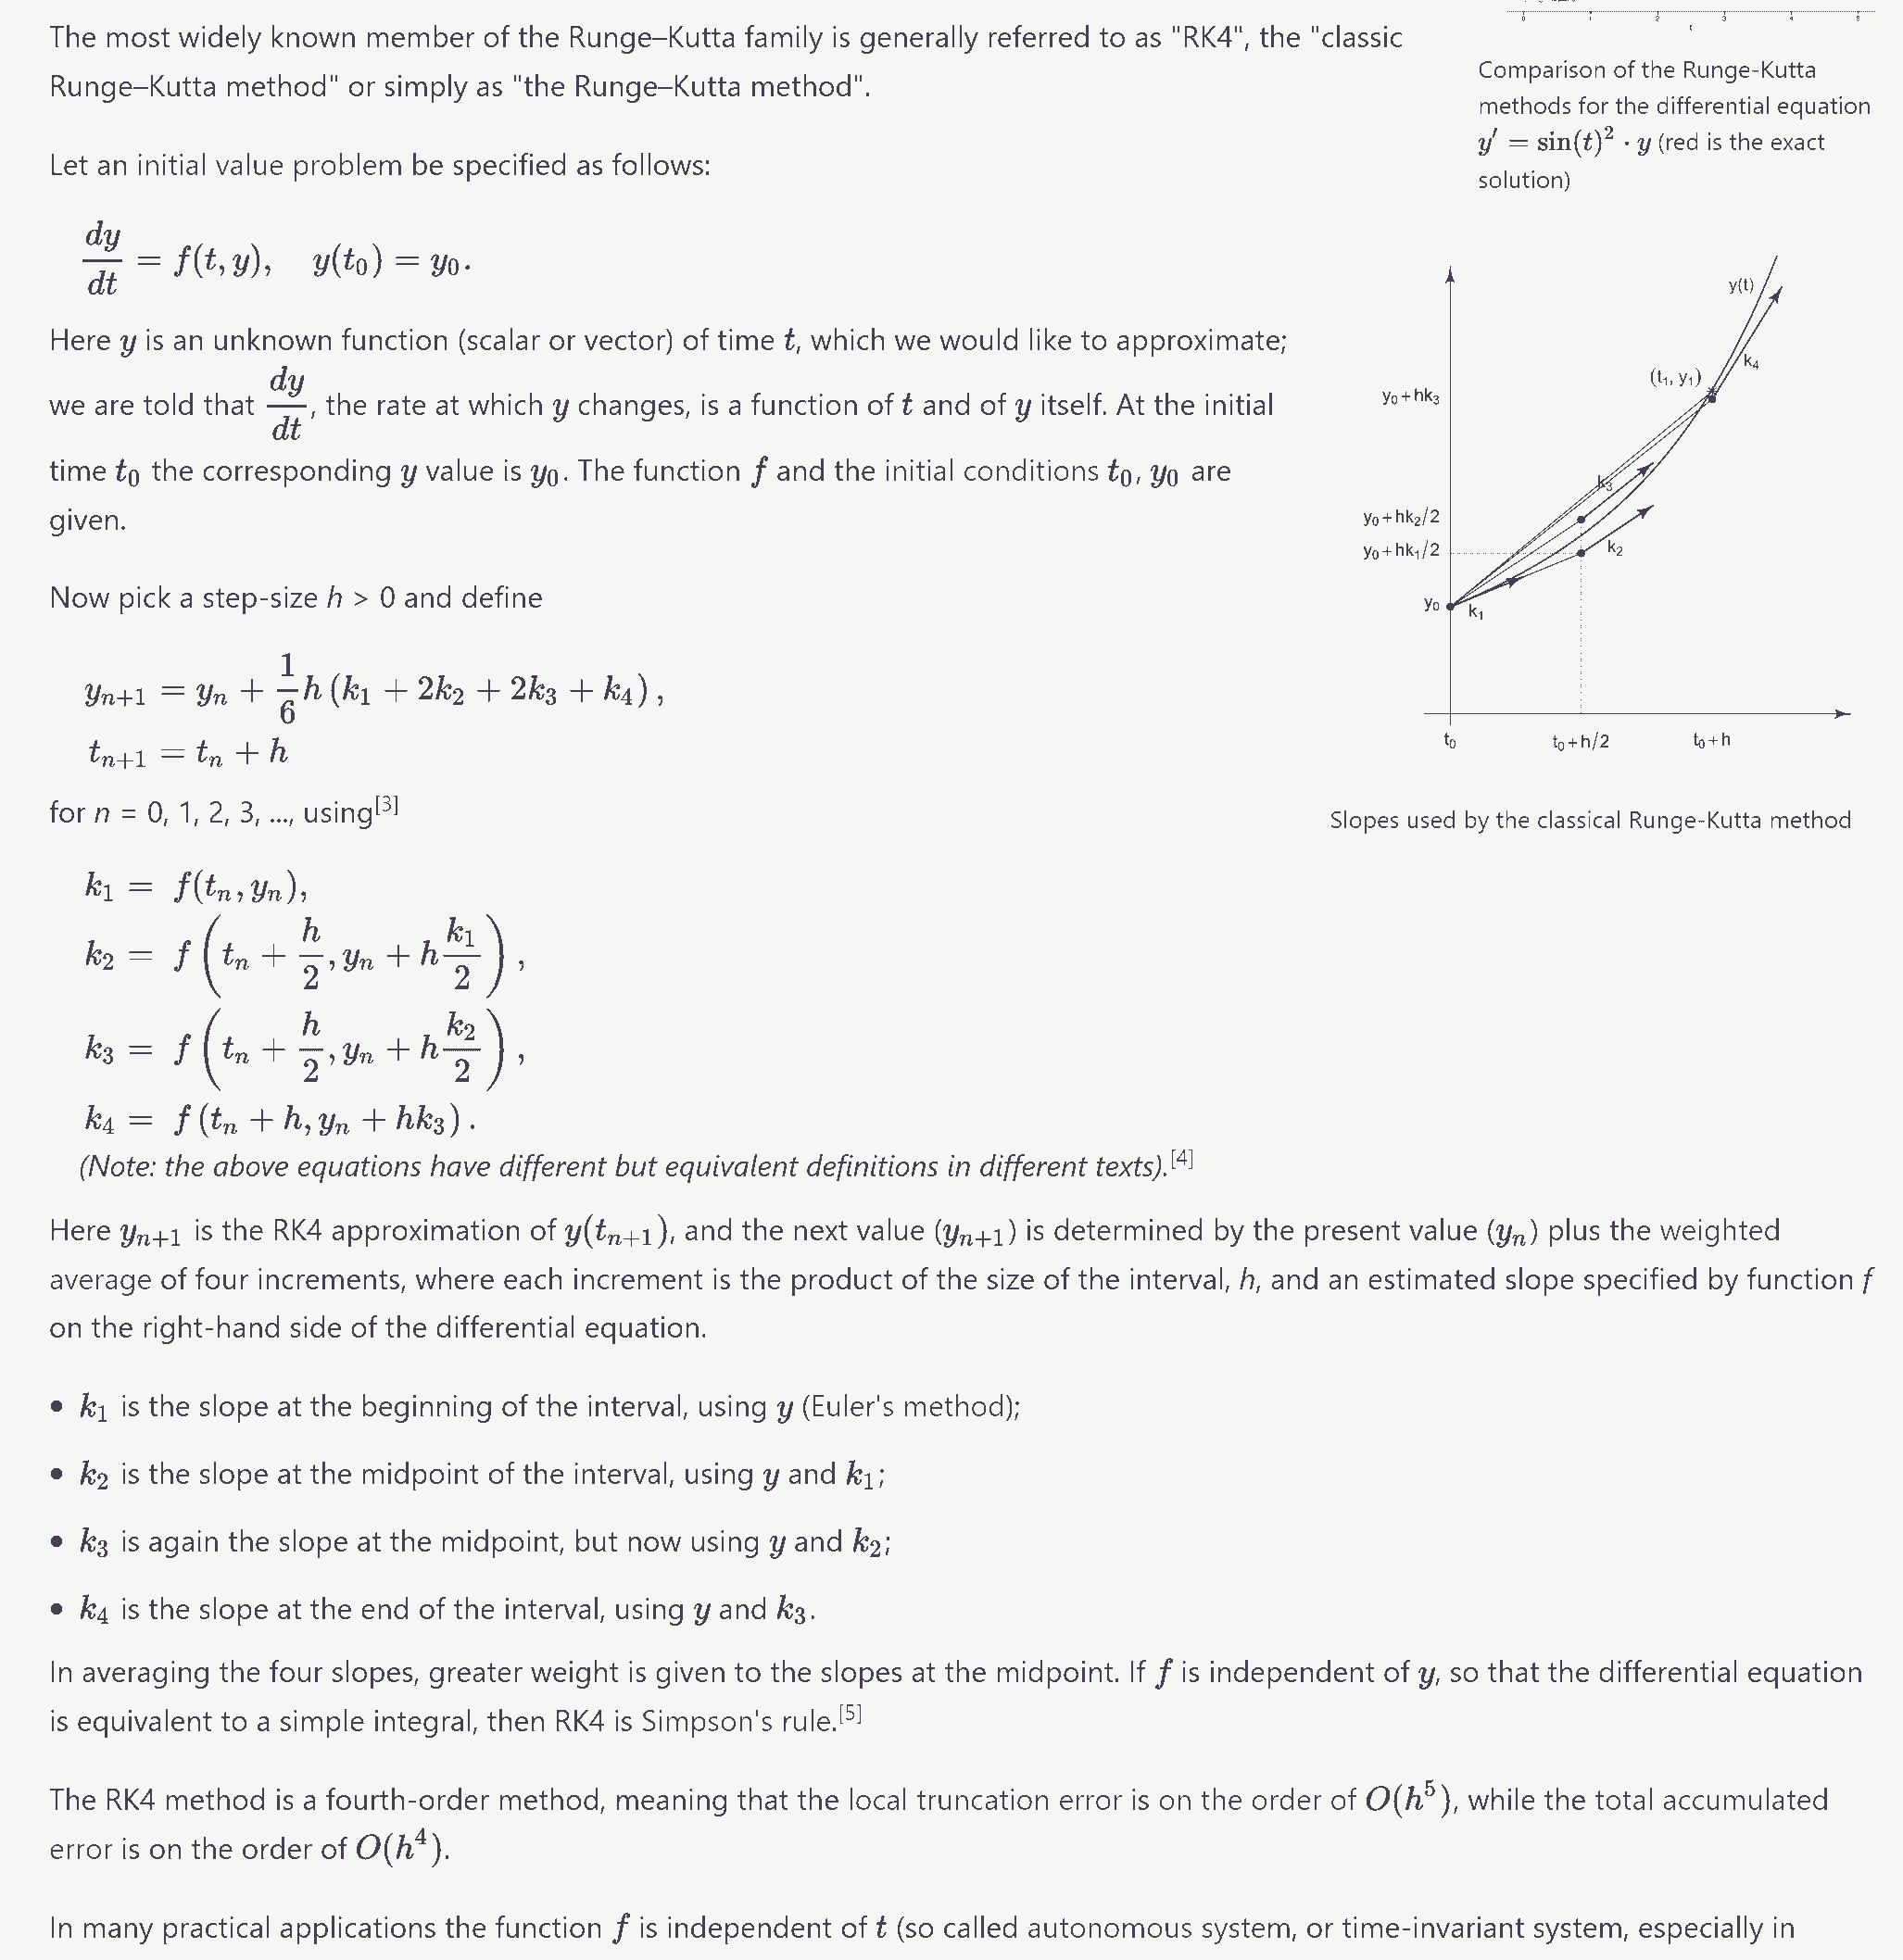

In [ ]:
#@title Default title text { vertical-output: true, display-mode: "both" }
variable_name = ""
def y( yn, tn):
  return yn/tn
  
def updatedYandT( yn, tn, h):
  k1 = y( yn, tn)
  k2 = y( yn + h * k1/2, tn + h/2)
  k3 = y( yn + h * k2/2, tn + h/2)
  k4 = y( yn + h * k3, tn + h)
  yn1 = yn + 1/6 * h * ( k1 + 2 * k2 + 2 * k3 + k4 )
  tn1 = tn + h
  return yn1, tn1



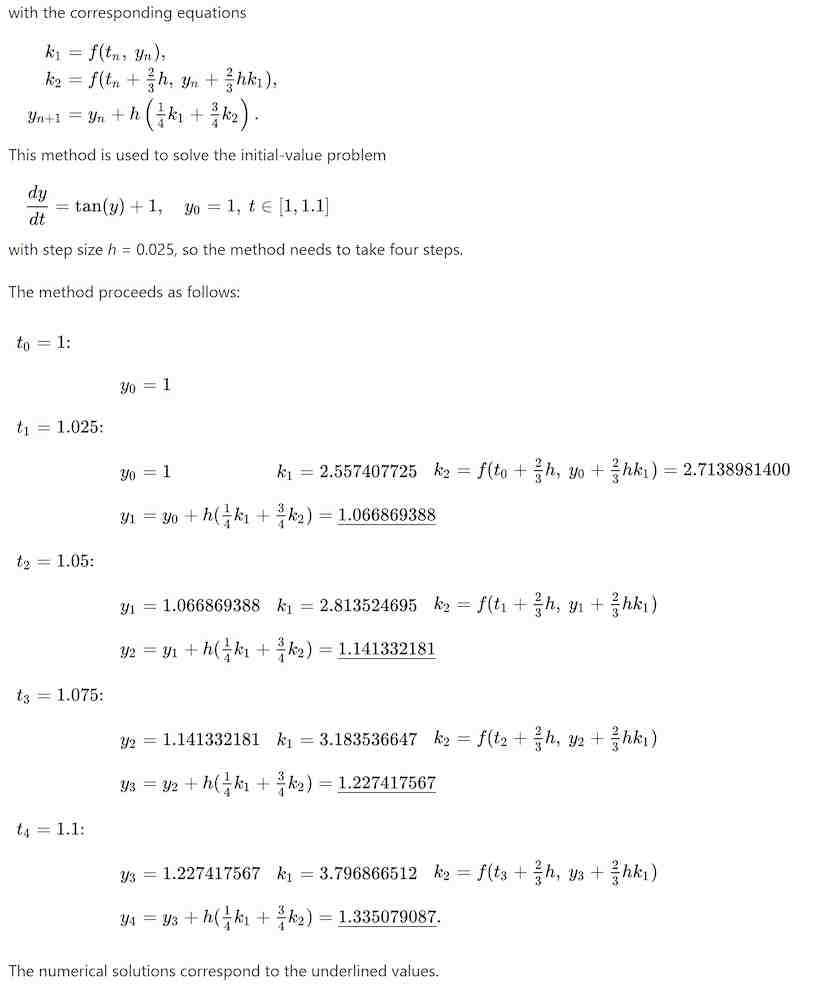

In [ ]:
import jax as jax


h = 0.025
def y( y, t):
  return -jax.numpy.log(jax.numpy.cos(y)) * t + t 
def x( y, t):
  return jax.numpy.tan(y) + 1

x = jax.numpy.linspace(1, 1.1, 5)

  
def updatedYandT( yn, tn, h):
  print("\nfor time t ::", tn)
  k1 = y( yn, tn) ;                                    print("  k1 = ", k1)
  k2 = y( yn + h * k1/2, tn + h/2) ;                   print("  k2 = ", k2)
  k3 = y( yn + h * k2/2, tn + h/2) ;                   print("  k3 = ", k3)
  k4 = y( yn + h * k3, tn + h) ;                       print("  k4 = ", k4)
  yn1 = yn + 1/6 * h * ( k1 + 2 * k2 + 2 * k3 + k4 ) ; print("  updated yn1 = ", yn1)
  tn1 = tn + h ;                                       print("  updated tn1 = ", tn1)
  return yn1, tn1

y0 = 1
t = 1
while (t <= 1.1):
  yy, tt = updatedYandT( y0, t, h)
  t = t + 0.001
y0 = 1
t = 1
yy, tt  = jax.vmap(updatedYandT)(1,x,0.025)
print(yy, tt)
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20  , 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title("$namw ofthe graph$")
ax.plot_surface(x, Y, z, rstride = 3, cstride = 3, cmap = 'cividis',antialiased=False, alpha=.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.zaxis.set_major_locator(plt.MultipleLocator(60))
plt.subplots_adjust(left=0.0)
ax.view_init(15, 45)
ax.axis('on')
plt.savefig('example.png', dpi=320)


for time t :: 1
  k1 =  1.6156266
  k2 =  1.6683899
  k3 =  1.6694784
  k4 =  1.7258421
  updated yn1 =  1.0417384
  updated tn1 =  1.025

for time t :: 1.001
  k1 =  1.6172422
  k2 =  1.6700709
  k3 =  1.671162
  k4 =  1.7275997
  updated yn1 =  1.0417805
  updated tn1 =  1.0259999999999998

for time t :: 1.0019999999999998
  k1 =  1.6188577
  k2 =  1.6717522
  k3 =  1.6728457
  k4 =  1.7293575
  updated yn1 =  1.0418226
  updated tn1 =  1.0269999999999997

for time t :: 1.0029999999999997
  k1 =  1.6204734
  k2 =  1.6734333
  k3 =  1.6745293
  k4 =  1.7311153
  updated yn1 =  1.0418646
  updated tn1 =  1.0279999999999996

for time t :: 1.0039999999999996
  k1 =  1.6220889
  k2 =  1.6751146
  k3 =  1.676213
  k4 =  1.7328734
  updated yn1 =  1.0419067
  updated tn1 =  1.0289999999999995

for time t :: 1.0049999999999994
  k1 =  1.6237047
  k2 =  1.6767962
  k3 =  1.6778972
  k4 =  1.7346318
  updated yn1 =  1.0419488
  updated tn1 =  1.0299999999999994

for time t :: 1.00599999999999

ValueError: ignored

In [ ]:
print(y(1,1))
print(jax.grad(y)(1.,1.))
print(jax.numpy.tan(1) + 1)

1.6156266
1.5574077
2.5574079


# Solving y=mx+b on a TPU

_part of the [solving y=mx+b... with jax on a tpu pod slice](http://matpalm.com/blog/ymxb_pod_slice/) blog series_

in the last colab we introduced some key jax transforms. 

in this colab we'll use them to fit a simple `y=mx+b` model using squared loss; both on a single device as well as across 8 devices in a data parallelism approach.

while the approach described here is clearly overkill for such a trivial model it's good to work through something simple to focus on the tooling

setup stuff for runtime TPU or CPU

In [ ]:
USE_TPU = True

if USE_TPU:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  # x8 cpu devices  
  import os
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

In [ ]:
import jax
assert len(jax.devices()) == 8
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import make_jaxpr

we start by generating training data for a simple line with a bit of noise

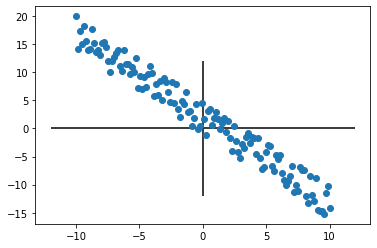

In [ ]:
def y(x, m, c):
  return m * x + c

x = np.linspace(-10, 10, num=128)
np.random.shuffle(x)

m_true = -1.5
b_true = 2.0

y_true = y(x, m_true, b_true)

noise = ((np.random.rand(*y_true.shape) * 2) - 1) * 3
y_true += noise

plt.plot(x, y_true, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

we will be trying to solve for `(m, b)` and can start with some arbitrary values, which are clearly wrong

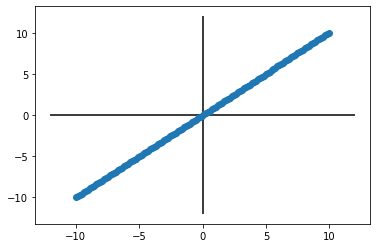

In [ ]:
m_model = 1.0
b_model = 0.0

y_pred = y(x, m_model, b_model)

plt.plot(x, y_pred, 'o')
plt.vlines(0, -12, 12)
plt.hlines(0, -12, 12)
plt.show()

we'll start by using `grad` for calculating an update to our model params `(m, b)` with respect to a loss function

In [ ]:
from jax import grad, jit

def sqr_loss(y_true, y_pred):
  return jnp.mean((y_true-y_pred)**2)

def loss_wrt_params(x, m, b, y_true):
  y_pred = y(x, m, b)
  return sqr_loss(y_true, y_pred)

# note: by dft grad calculates gradients w.r.t the first arg
#  but in this case we want it w.r.t. m & b, i.e. args 1 & 2
gradient_wrt_loss = jit(grad(loss_wrt_params, argnums=(1, 2)))

m_grad, b_grad = gradient_wrt_loss(x, m_true, b_true, y_true)
print("for true: m_grad", m_grad, "b_grad", b_grad)

m_grad, b_grad = gradient_wrt_loss(x, m_model, b_model, y_true)
print("for model params: m_grad", m_grad, "b_grad", b_grad)

for true: m_grad 0.8058947 b_grad -0.15326717
for model params: m_grad 170.09723 b_grad -4.1532674


we can use this gradient to run a trivial learning loop

In [ ]:
m, b = 1.0, 0.0
learning_rate = 0.01

print("true", m_true, b_true)
for _ in range(30):
  m_grad, b_grad = gradient_wrt_loss(x, m_model, b_model, y_true)
  m_model -= learning_rate * m_grad 
  b_model -= learning_rate * b_grad 
  print("grads", m_grad, b_grad, "=> model", m_model, b_model)

true -1.5 2.0
grads 170.09723 -4.1532674 => model -0.7009722 0.041532673
grads 54.913303 -4.070202 => model -1.2501051 0.082234696
grads 17.727913 -3.9887989 => model -1.4273843 0.12212268
grads 5.7231803 -3.9090216 => model -1.484616 0.16121289
grads 1.8476418 -3.8308408 => model -1.5030924 0.1995213
grads 0.5964879 -3.7542245 => model -1.5090573 0.23706356
grads 0.19256687 -3.6791399 => model -1.510983 0.27385497
grads 0.06216503 -3.6055567 => model -1.5116047 0.30991054
grads 0.020068005 -3.5334456 => model -1.5118053 0.345245
grads 0.006481573 -3.4627762 => model -1.5118701 0.37987277
grads 0.0020901859 -3.3935223 => model -1.511891 0.413808
grads 0.000677228 -3.3256516 => model -1.5118978 0.44706452
grads 0.00021700561 -3.2591379 => model -1.5119 0.4796559
grads 7.1428716e-05 -3.1939547 => model -1.5119007 0.5115954
grads 2.2865832e-05 -3.1300757 => model -1.5119009 0.5428962
grads 6.8619847e-06 -3.0674748 => model -1.511901 0.57357097
grads -8.7171793e-07 -3.0061245 => model -1.5

## pytrees

before we start though we should know that most models have more than 2 params. another thing we can do then is make use of the fact that the fundamental jax operators can work with dictionaries of params, called [pytrees](https://jax.readthedocs.io/en/latest/pytrees.html). this allows us to work with a single `params` object rather than clumsily having to manage single parameters

In [ ]:
def y(params, x):
  return params['m'] * x + params['b']

def mean_sqrd_loss(params, x, y_true):
  y_pred = y(params, x)
  loss = (y_pred - y_true) ** 2
  return jnp.mean(loss)

note how transforms like `grad` are pytree aware and it return gradients in the same structure as the params

In [ ]:
true_params = {'m': m_true, 'b': b_true}
model_params = {'m': 1.0, 'b': 0.0}

# recall signature: mean_sqrd_loss(params, x, y_true)
# note: grad takes gradients with respect to first arg
grads = jit(grad(mean_sqrd_loss))

print("grads w.r.t true_params", grads(true_params, x, y_true))
print("grads w.r.t model_params", grads(model_params, x, y_true))

grads w.r.t true_params {'b': DeviceArray(-0.15326717, dtype=float32), 'm': DeviceArray(0.8058947, dtype=float32)}
grads w.r.t model_params {'b': DeviceArray(-4.1532674, dtype=float32), 'm': DeviceArray(170.09723, dtype=float32)}


##pmap

let's run `pmap` to calc gradients in parallel. we'll reshape the input `(x, y)` data so we can `pmap` it across the 8 devices. we won't `pmap` across the model params `m` or `b`. this is effectively running a data parallel approach where each device runs the same model, but on 1/8th of the data. 

In [ ]:
# reshape x and y_true to 8 sets of 16 examples

x = x.reshape((8, 16))
y_true = y_true.reshape((8, 16))

if we pmap over the gradient calc directly what we end up getting is the 8 sets of gradients, each of which corresponds to the 16 examples that were provided. note how this represents the fundamental data parallelism approach.

In [ ]:
from jax import pmap

# recall signature: mean_sqrd_loss(params, x, y_true)
p_grads = pmap(grad(mean_sqrd_loss), in_axes=(None, 0, 0))
p_grads(model_params, x, y_true)

{'b': ShardedDeviceArray([ -0.8038659,  -9.862819 , -14.980595 ,  -3.5736265,
                      -5.3239856,   0.8262547,   3.7233787,  -3.2308824],                   dtype=float32),
 'm': ShardedDeviceArray([155.22513, 180.37373, 181.12679, 196.06383, 179.2839 ,
                     131.51302, 197.15901, 140.03242], dtype=float32)}

at this point we have the gradients for each of the 8 batches of 16. we can sum these gradients and use them for an update.

In [ ]:
g = p_grads(model_params, x, y_true)
g = {k: jnp.sum(v) for k, v in g.items()}
g

{'b': DeviceArray(-33.226143, dtype=float32),
 'm': DeviceArray(1360.7778, dtype=float32)}

this kind of application of a function (like sum) to elements of a dictionary is pretty common when you represent params in dictionaries. to support operations on these jax provides a selection of `tree_utils` including `tree_map`. tree_map (and friends) can handle all kinds of potentially nested structures and run their operation on the leafs of the dict structure.

In [ ]:
from jax.tree_util import tree_map 

g = p_grads(model_params, x, y_true)
g = tree_map(jnp.sum, g)
g

{'b': DeviceArray(-33.226143, dtype=float32),
 'm': DeviceArray(1360.7778, dtype=float32)}

turns out this sum across all the 8 devices is something we can also do _inside_ the `pmap` call, not just after it. so far we've only used pmap to do independent calculations but there are a number of parallel ops we can call that operate _across_ the devices. in this case we can use `psum`. 

note how since `pmap` always returns a sharded value based on the #devices it broadcasts the gradients out to a replicated (8, 1) array. 

In [ ]:
from jax.lax import psum

def p_grads(params, x, y_true):
  grads = jit(grad(mean_sqrd_loss))(params, x, y_true)
  grads = tree_map(lambda v: psum(v, 'device'), grads)
  return grads

p_grads = pmap(p_grads, in_axes=(None, 0, 0), axis_name='device')

model_params = {'m': 1.0, 'b': 0.0}
p_grads(model_params, x, y_true)

{'b': ShardedDeviceArray([-33.226143, -33.226143, -33.226143, -33.226143,
                     -33.226143, -33.226143, -33.226143, -33.226143],                   dtype=float32),
 'm': ShardedDeviceArray([1360.7778, 1360.7778, 1360.7778, 1360.7778, 1360.7778,
                     1360.7778, 1360.7778, 1360.7778], dtype=float32)}

we've done the forward pass, the loss calc and now gradients all in parallel. what about the actual model update? we can do that in the `pmap` call too! we use the `tree_multimap` helper to update the params (a pytree) from the gradients (another pytree)

In [ ]:
from jax.tree_util import tree_multimap

def p_update(params, x, y_true):
  # calculate gradients summing across all devices
  grads = jit(grad(mean_sqrd_loss))(params, x, y_true)
  grads = tree_map(lambda v: psum(v, 'device'), grads)  
  # apply update
  def update(p, g):  
    learning_rate = 0.001
    return p - learning_rate * g
  new_params = tree_multimap(update, params, grads)
  # return new params
  return new_params

p_update = pmap(p_update, in_axes=(None, 0, 0), axis_name='device')

model_params = {'m': 1.0, 'b': 0.0}
p_update(model_params, x, y_true)

{'b': ShardedDeviceArray([0.03322614, 0.03322614, 0.03322614, 0.03322614,
                     0.03322614, 0.03322614, 0.03322614, 0.03322614],                   dtype=float32),
 'm': ShardedDeviceArray([-0.36077785, -0.36077785, -0.36077785, -0.36077785,
                     -0.36077785, -0.36077785, -0.36077785, -0.36077785],                   dtype=float32)}

_cut to pod slice demo_

note: this TPU experience isn't publicly available yet but you can sign up for early access via the [JAX on Cloud TPU Interest Form](http://goo.gle/jax-tpu-signup)

for more information see the [JAX on Cloud TPUs (NeurIPS 2020)](https://docs.google.com/presentation/d/1eBfNKT3D3lEWtcn4mkgvvitKZTU7HSn4f3fGHqYgpeA/)

again notice how in the return values the params are being promoted from scalars to sharded arrays . if we want to include this in some kind of `params = update(params)` kind of loop we need to also _start_ with a sharded set. we can do this by replicating the single model params across all the devices.

In [ ]:
def shard(x):
  return pmap(lambda v: v)(x)

def replicate(x, replicas=8):  
  replicated = jnp.stack([x] * replicas)
  return shard(replicated)

model_params = {'m': 1.0, 'b': 0.0}
model_params = tree_map(replicate, model_params)
model_params

{'b': ShardedDeviceArray([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'm': ShardedDeviceArray([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)}

and, while we're sharding, we might as well explicitly shard x and y too which has the nice side effect of replicating across the devices

In [ ]:
x = shard(x)
y_true = shard(y_true)
  
x.shape, type(x)

((8, 16), jax.interpreters.pxla._ShardedDeviceArray)

we now have everything we need to run this in across the eight devices in an as parallel way as possible

* the model params, x and y, are replicated across all 8 devices. i.e. all 8 devices have a copy of the same params.
* the data is also sharded aross the 8 devices. i.e. each device has 1/8th of the original data
* the forward pass, loss, gradient calc & param update is done in parallel with a minimal combine step for gradients.


In [ ]:
from jax import value_and_grad

def p_update(params, x, y_true):
  # calculate gradients
  loss, grads = jit(value_and_grad(mean_sqrd_loss))(params, x, y_true)
  # do all reduce sum across all replicas
  grads = tree_map(lambda v: psum(v, 'device'), grads)  
  # apply update
  def update(p, g):  
    learning_rate = 0.001
    return p - learning_rate * g
  new_params = tree_multimap(update, params, grads)
  return new_params, loss

# note: we pmap across _all_ args now; model_params, x and y
p_update = pmap(p_update, in_axes=(0, 0, 0), axis_name='device')

for i in range(20):
  model_params, loss = p_update(model_params, x, y_true)  
  print("step", i, "loss", jnp.mean(loss), 
        "m", model_params['m'][0], "b", model_params['b'][0])

step 0 loss 5.5652704 m -1.5119008 b 0.5966499
step 1 loss 5.49346 m -1.5119009 b 0.6203296
step 2 loss 5.4239297 m -1.5119009 b 0.6436305
step 3 loss 5.3566065 m -1.5119009 b 0.66655856
step 4 loss 5.2914205 m -1.5119009 b 0.68911976
step 5 loss 5.228304 m -1.5119009 b 0.71132
step 6 loss 5.16719 m -1.5119009 b 0.733165
step 7 loss 5.108017 m -1.5119009 b 0.75466055
step 8 loss 5.0507216 m -1.5119009 b 0.7758121
step 9 loss 4.9952455 m -1.5119009 b 0.79662526
step 10 loss 4.9415307 m -1.5119009 b 0.8171054
step 11 loss 4.88952 m -1.5119009 b 0.83725786
step 12 loss 4.8391614 m -1.5119009 b 0.85708785
step 13 loss 4.7904005 m -1.5119009 b 0.87660056
step 14 loss 4.743188 m -1.5119009 b 0.89580107
step 15 loss 4.6974745 m -1.5119009 b 0.91469437
step 16 loss 4.653211 m -1.5119009 b 0.9332854
step 17 loss 4.610354 m -1.5119009 b 0.951579
step 18 loss 4.568857 m -1.5119009 b 0.9695799
step 19 loss 4.528677 m -1.5119009 b 0.98729277


what a way to solve `y=mx+b` !!

# JaxModel_and_PINNModel

In [ ]:
!pip install --pre deepchem[jax]

     |████████████████████████████████| 609 kB 11.0 MB/s 
     |████████████████████████████████| 118 kB 52.6 MB/s 
     |████████████████████████████████| 284 kB 30.1 MB/s 
     |████████████████████████████████| 57 kB 6.0 MB/s 


In [ ]:
import numpy as np
import functools
try:
  import jax
  import jax.numpy as jnp
  import haiku as hk
  import optax
  from deepchem.models import PINNModel, JaxModel
  from deepchem.data import NumpyDataset
  from deepchem.models.optimizers import Adam
  from jax import jacrev
  has_haiku_and_optax = True
except:
  has_haiku_and_optax = False




## Given Physical Data

We have a 10 random points between $x\in [-2\pi, 2\pi]$ and its corresponding value f(x)

We know that data follows an underlying physical rule that

$\frac{df(x)}{dx} = -sin(x) $



Text(0.5, 1.0, 'Data of our physical system')

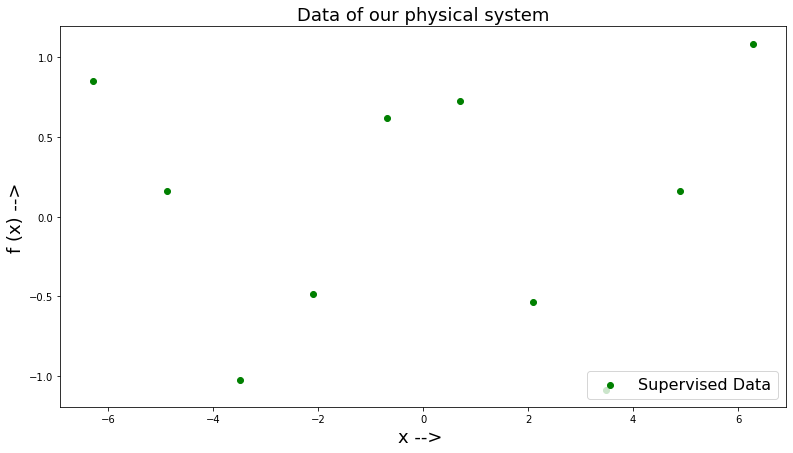

In [ ]:
import matplotlib.pyplot as plt

give_size = 10
in_given = np.linspace(-2 * np.pi, 2 * np.pi, give_size)
out_given = np.cos(in_given) + 0.1*np.random.normal(loc=0.0, scale=1, size=give_size)



# red for numpy.sin()
plt.figure(figsize=(13, 7))

plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Supervised Data"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)


From simple integeration, we can easily solve the diffrential equation and the solution will be - 

$f(x) = cos(x)$

Text(0.5, 1.0, 'Data of our physical system')

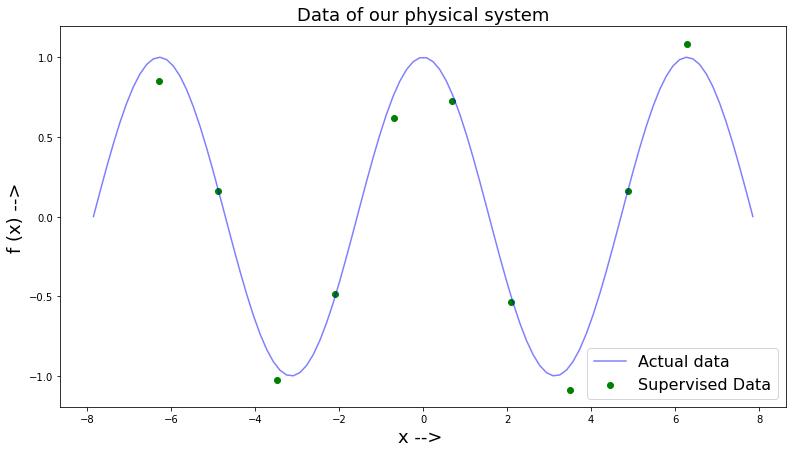

In [ ]:
import matplotlib.pyplot as plt

test = np.expand_dims(np.linspace(-2.5 * np.pi, 2.5 * np.pi, 100), 1)
out_array = np.cos(test)

plt.figure(figsize=(13, 7))
plt.plot(test, out_array, color = 'blue', alpha = 0.5)
plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Actual data" ,"Supervised Data"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)


## Building a Simple Neural Network Model - 

We define a simple Feed-forward Neural Network with 2 hidden layers of size 256 & 128 neurons.

In [ ]:
# defining the Haiku model

# A neural network is defined as a function of its weights & operations.
# NN(x) = F(x, W) 

# forward function defines the F which describes the mathematical operations like Matrix & dot products, Signmoid functions, etc
# W is the init_params

def f(x):
  net = hk.nets.MLP(output_sizes=[256, 128, 1], activation=jax.nn.softplus)
  val = net(x)
  return val

init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(500)
params = init_params(rng, np.random.rand(1000, 1))


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3634: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


## Fitting a simple Neural Network solution to the Physical Data

In [ ]:

train_dataset = NumpyDataset(np.expand_dims(in_given, axis=1), np.expand_dims(out_given, axis=1))
rms_loss = lambda pred, tar, w: jnp.mean(optax.l2_loss(pred, tar))
# JaxModel Working
nn_model = JaxModel(
    forward_fn,
    params,
    rms_loss,
    batch_size=100,
    learning_rate=0.001,
    log_frequency=2)
nn_model.fit(train_dataset, nb_epochs=10000, deterministic=True)



/usr/local/lib/python3.7/dist-packages/deepchem/models/jax_models/jax_model.py:160: UserWarning: JaxModel is still in active development and all features may not yet be implemented
  'JaxModel is still in active development and all features may not yet be implemented'


2.1729056921826473e-11

Text(0.5, 1.0, 'Data of our physical system')

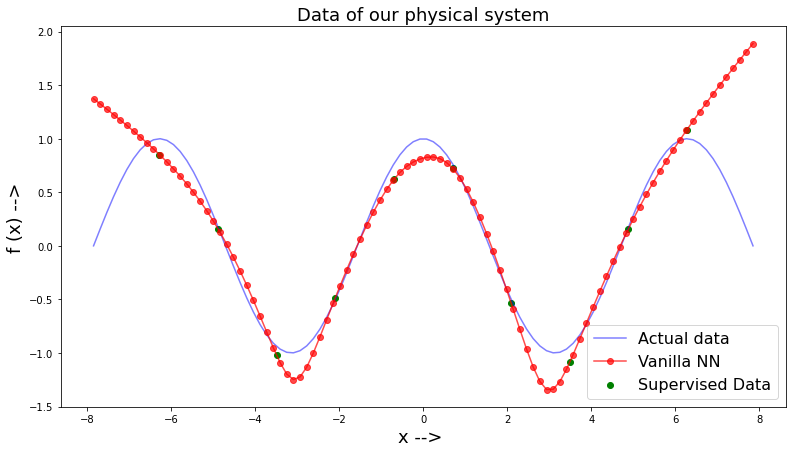

In [ ]:
dataset_test = NumpyDataset(test)
nn_output = nn_model.predict(dataset_test)

plt.figure(figsize=(13, 7))
plt.plot(test, out_array, color = 'blue', alpha = 0.5)
plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.plot(test, nn_output, color = 'red', marker = "o", alpha = 0.7)
plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Actual data", "Vanilla NN", "Supervised Data"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)

## Learning to fit the Data using the underlying Diffrential equation

Lets ensure that final output of the neural network satisfies the diffrential equation as a loss function- 

In [ ]:
def create_eval_fn(forward_fn, params):
  """
    Calls the function to evaluate the model
  """

  @jax.jit
  def eval_model(x, rng=None):

    bu = forward_fn(params, rng, x)
    return jnp.squeeze(bu)

  return eval_model

def gradient_fn(forward_fn, loss_outputs, initial_data):
  """
  This function calls the gradient function, to implement the backpropagation
  """
  boundary_data = initial_data['X0']
  boundary_target = initial_data['u0']

  @jax.jit
  def model_loss(params, target, weights, rng, x_train):

    @functools.partial(jax.vmap, in_axes=(None, 0))
    def periodic_loss(params, x):
      """
      diffrential equation => grad(f(x)) = - sin(x)
      minimize f(x) := grad(f(x)) + sin(x)
      """
      x = jnp.expand_dims(x, 0)
      u_x = jacrev(forward_fn, argnums=(2))(params, rng, x)
      return u_x + jnp.sin(x)

    u_pred = forward_fn(params, rng, boundary_data)
    loss_u = jnp.mean((u_pred - boundary_target)**2)

    f_pred = periodic_loss(params, x_train)
    loss_f = jnp.mean((f_pred**2))

    return loss_u + loss_f

  return model_loss


In [ ]:



initial_data = {
    'X0': jnp.expand_dims(in_given, 1),
    'u0': jnp.expand_dims(out_given, 1)
}
opt = Adam(learning_rate=1e-3)
pinn_model= PINNModel(
    forward_fn=forward_fn,
    params=params,
    initial_data=initial_data,
    batch_size=1000,
    optimizer=opt,
    grad_fn=gradient_fn,
    eval_fn=create_eval_fn,
    deterministic=True,
    log_frequency=1000)

# defining our training data. We feed 100 points between [-2.5pi, 2.5pi] without the labels,
# which will be used as the differential loss(regulariser)
X_f = np.expand_dims(np.linspace(-3 * np.pi, 3 * np.pi, 1000), 1)
dataset = NumpyDataset(X_f)
pinn_model.fit(dataset, nb_epochs=3000)


/usr/local/lib/python3.7/dist-packages/deepchem/models/jax_models/pinns_model.py:157: UserWarning: PinnModel is still in active development and we could change the design of the API in the future.
  'PinnModel is still in active development and we could change the design of the API in the future.'
/usr/local/lib/python3.7/dist-packages/deepchem/models/jax_models/jax_model.py:160: UserWarning: JaxModel is still in active development and all features may not yet be implemented
  'JaxModel is still in active development and all features may not yet be implemented'


0.026332732232287527

Text(0.5, 1.0, 'Data of our physical system')

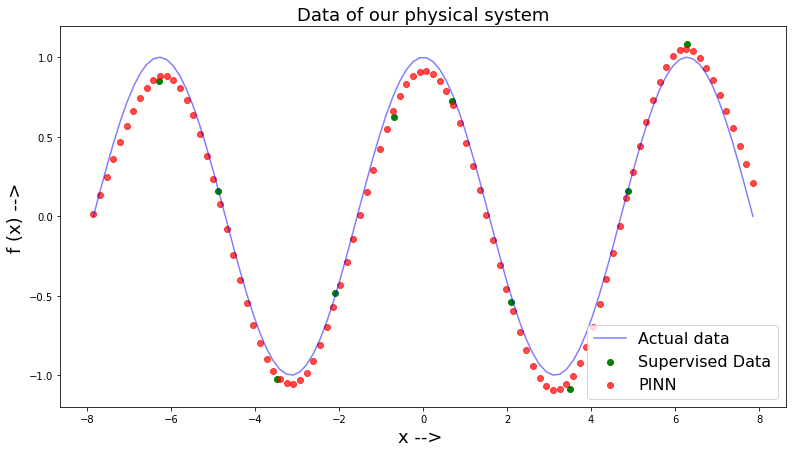

In [ ]:
import matplotlib.pyplot as plt

pinn_output = pinn_model.predict(dataset_test)

plt.figure(figsize=(13, 7))
plt.plot(test, out_array, color = 'blue', alpha = 0.5)
plt.scatter(in_given, out_given, color = 'green', marker = "o")
# plt.plot(test, nn_output, color = 'red', marker = "x", alpha = 0.3)
plt.scatter(test, pinn_output, color = 'red', marker = "o", alpha = 0.7)

plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Actual data" ,"Supervised Data", "PINN"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)

## Comparing the results between PINN & Vanilla NN model

Text(0.5, 1.0, 'Data of our physical system')

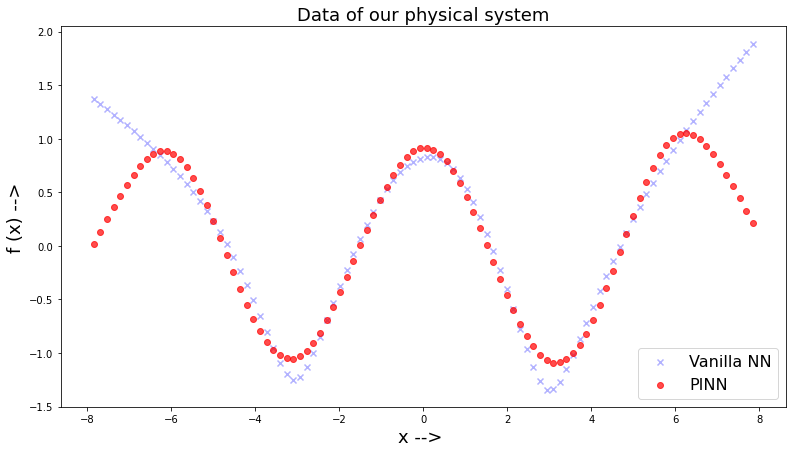

In [ ]:

plt.figure(figsize=(13, 7))
# plt.plot(test, out_array, color = 'blue', alpha = 0.5)
# plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.scatter(test, nn_output, color = 'blue', marker = "x", alpha = 0.3)
plt.scatter(test, pinn_output, color = 'red', marker = "o", alpha = 0.7)

plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Vanilla NN", "PINN"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)